In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Going to create voting ensemble model on top 20 authors second

In [2]:
import os
from nltk import word_tokenize
import string
import itertools
import pandas as pd
import re

data_path = r'./Gutenberg/txt'

records_dict_list = []

for txt_filename in os.listdir(data_path):
    if txt_filename.endswith(".txt"):
        try:
            author, title = txt_filename.split('.')[0].split('___')
            with open(os.path.join(data_path, txt_filename), "r", encoding="utf-8") as f:
                content = f.read()
            data = {'author': author, 'title': title, 'text': content}
            records_dict_list.append(data)
        except Exception:
            print('not found' + data_path + "/" + txt_filename)
        
result_df = pd.DataFrame.from_dict(records_dict_list)

In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip(' ')
    return text

In [4]:
# Create data folder if it doesn't already exist
if os.path.isdir('./data') == False:
    print('Data folder does not exist. It has been created.')
    os.mkdir('./data/')
else:
    print("Folder data already exists")

Data folder does not exist. It has been created.


In [5]:
result_df[['author','title']].to_csv('./data/works.csv')

In [6]:
counts = result_df.author.value_counts().nlargest(20)
counts_df = pd.DataFrame({'author':counts.index, 'title_count':counts.values})
counts_df

,author,title_count
0,William Wymark Jacobs,97
1,George Alfred Henty,89
2,R M Ballantyne,88
3,Nathaniel Hawthorne,86
4,William Dean Howells,84
5,Robert Louis Stevenson,79
6,Henry James,72
7,Anthony Trollope,71
8,Charles Dickens,61
9,Charlotte Mary Yonge,60


In [7]:
# Grab the top 20 most prolific authors and their works.
result_df = result_df[result_df.author.isin(list(counts_df.author.unique()))].reset_index(drop=True)

result_df['text'] = result_df['text'].map(lambda words : clean_text(words))
result_df.to_csv('./data/result_df.csv')

In [8]:
from SPARQLWrapper import SPARQLWrapper, JSON

sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

In [9]:
wiki_list = []
for author in list(counts_df.author.unique()):
    try:
        if author == 'R M Ballantyne':
            author = 'Robert Michael Ballantyne'
        sparql.setQuery("""
        SELECT distinct ?item ?itemLabel ?itemDescription ?placeofbirthLabel ?placeofbirth ?birthLocation ?coordinates (SAMPLE(?DR) as ?DR) (SAMPLE(?RIP) as ?RIP) (SAMPLE(?article)as ?article) WHERE {
    ?item wdt:P31 wd:Q5.
    ?item ?label "%s"@en.
    ?item wdt:P19 ?placeofbirth.
    ?item wdt:P19 ?birthLocation.
    ?birthLocation wdt:P625 ?coordinates.
    ?article schema:about ?item .
    ?article schema:inLanguage "en" .
    ?article schema:isPartOf <https://en.wikipedia.org/>.  
    OPTIONAL{?item wdt:P569 ?DR .} # P569 : Date of birth
    OPTIONAL{?item wdt:P570 ?RIP .}     # P570 : Date of death
    OPTIONAL{?item wdt:P18 ?image .}     # P18 : image  

    SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }    
    }
    GROUP BY ?item ?itemLabel ?itemDescription ?placeofbirthLabel ?placeofbirth ?birthLocation ?coordinates
    ORDER BY DESC(?DR)
    limit 1
        """%author)
        sparql.setReturnFormat(JSON)
        wiki_results = sparql.query().convert()
        wiki_results_df = pd.io.json.json_normalize(wiki_results['results']['bindings'])
        wiki_list.append(wiki_results_df[['itemLabel.value', 'placeofbirthLabel.value', 'placeofbirth.value', 'coordinates.value']])
    except:
        print("could not find placeofbirth for {}".format(author))
pob_df = pd.concat(wiki_list)
pob_df = pob_df.reset_index(drop=True)
pob_df.to_csv('data/placeofbirth_df.csv')

/Users/danielkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [10]:
# !pip install wheel
# !pip install pipwin
# !pipwin install numpy
# !pipwin install pandas
# !pipwin install shapely
# !pipwin install gdal
# !pipwin install fiona
# !pipwin install pyproj
# !pipwin install six
# !pipwin install rtree
# !pipwin install geopandas

In [29]:
pob_df

,itemLabel.value,placeofbirthLabel.value,placeofbirth.value,coordinates.value,geometry
0,W. W. Jacobs,Wapping,http://www.wikidata.org/entity/Q124046,Point(-0.061 51.5073),POINT (-0.06100 51.50730)
1,G. A. Henty,Cambridge,http://www.wikidata.org/entity/Q350,Point(0.1225 52.208055555),POINT (0.12250 52.20806)
2,Robert Michael Ballantyne,Edinburgh,http://www.wikidata.org/entity/Q23436,Point(-3.198888888 55.95),POINT (-3.19889 55.95000)
3,Nathaniel Hawthorne,Salem,http://www.wikidata.org/entity/Q54140,Point(-70.898503 42.516845),POINT (-70.89850 42.51685)
4,William Dean Howells,Belmont County,http://www.wikidata.org/entity/Q485513,Point(-80.99 40.02),POINT (-80.99000 40.02000)
5,Robert Louis Stevenson,Edinburgh,http://www.wikidata.org/entity/Q23436,Point(-3.198888888 55.95),POINT (-3.19889 55.95000)
6,Henry James,Centreville,http://www.wikidata.org/entity/Q79253,Point(-87.134708 32.95),POINT (-87.13471 32.95000)
7,Anthony Trollope,London,http://www.wikidata.org/entity/Q84,Point(-0.1275 51.507222222),POINT (-0.12750 51.50722)
8,Charles Dickens,Landport,http://www.wikidata.org/entity/Q1803681,Point(-1.087 50.803),POINT (-1.08700 50.80300)
9,Charlotte Mary Yonge,Otterbourne,http://www.wikidata.org/entity/Q1952484,Point(-1.342880555 51.007238888),POINT (-1.34288 51.00724)


In [30]:
from shapely import wkt
pob_df['geometry'] = pob_df['coordinates.value'].apply(wkt.loads)

In [31]:
import geopandas as gpd
geo_df = gpd.GeoDataFrame(pob_df, geometry='geometry')

In [32]:
geo_df

,itemLabel.value,placeofbirthLabel.value,placeofbirth.value,coordinates.value,geometry
0,W. W. Jacobs,Wapping,http://www.wikidata.org/entity/Q124046,Point(-0.061 51.5073),POINT (-0.06100 51.50730)
1,G. A. Henty,Cambridge,http://www.wikidata.org/entity/Q350,Point(0.1225 52.208055555),POINT (0.12250 52.20806)
2,Robert Michael Ballantyne,Edinburgh,http://www.wikidata.org/entity/Q23436,Point(-3.198888888 55.95),POINT (-3.19889 55.95000)
3,Nathaniel Hawthorne,Salem,http://www.wikidata.org/entity/Q54140,Point(-70.898503 42.516845),POINT (-70.89850 42.51685)
4,William Dean Howells,Belmont County,http://www.wikidata.org/entity/Q485513,Point(-80.99 40.02),POINT (-80.99000 40.02000)
5,Robert Louis Stevenson,Edinburgh,http://www.wikidata.org/entity/Q23436,Point(-3.198888888 55.95),POINT (-3.19889 55.95000)
6,Henry James,Centreville,http://www.wikidata.org/entity/Q79253,Point(-87.134708 32.95),POINT (-87.13471 32.95000)
7,Anthony Trollope,London,http://www.wikidata.org/entity/Q84,Point(-0.1275 51.507222222),POINT (-0.12750 51.50722)
8,Charles Dickens,Landport,http://www.wikidata.org/entity/Q1803681,Point(-1.087 50.803),POINT (-1.08700 50.80300)
9,Charlotte Mary Yonge,Otterbourne,http://www.wikidata.org/entity/Q1952484,Point(-1.342880555 51.007238888),POINT (-1.34288 51.00724)


In [33]:
counts_authors = list(counts_df.sort_values(by=['author']).author)

geo_authors = list(geo_df.sort_values(by=['itemLabel.value'])['itemLabel.value'])
geo_authors.insert(17, geo_authors.pop(2))
geo_authors.insert(18, geo_authors.pop(19))
geo_authors.insert(16, geo_authors.pop(15))
geo_authors.insert(8, geo_authors.pop(9))
geo_authors.insert(8, geo_authors.pop(10))

In [34]:
joined_authors = pd.DataFrame(
    {'counts_author': counts_authors,
     'geo_author': geo_authors
    })

joined_authors['lda_file'] = joined_authors['counts_author'].apply(lambda x: x.lower().replace(" ", '_')+'_LDA.html')
joined_authors.to_csv('./data/author_list.csv')

In [36]:
joined_authors

,counts_author,geo_author,lda_file
0,Andrew Lang,Andrew Lang,andrew_lang_LDA.html
1,Anthony Trollope,Anthony Trollope,anthony_trollope_LDA.html
2,Bret Harte,Bret Harte,bret_harte_LDA.html
3,Charles Dickens,Charles Dickens,charles_dickens_LDA.html
4,Charlotte Mary Yonge,Charlotte Mary Yonge,charlotte_mary_yonge_LDA.html
5,Edward Phillips Oppenheim,E. Phillips Oppenheim,edward_phillips_oppenheim_LDA.html
6,Edward Stratemeyer,Edward Stratemeyer,edward_stratemeyer_LDA.html
7,George Alfred Henty,G. A. Henty,george_alfred_henty_LDA.html
8,Henry James,Henry James,henry_james_LDA.html
9,Henry Rider Haggard,H. Rider Haggard,henry_rider_haggard_LDA.html


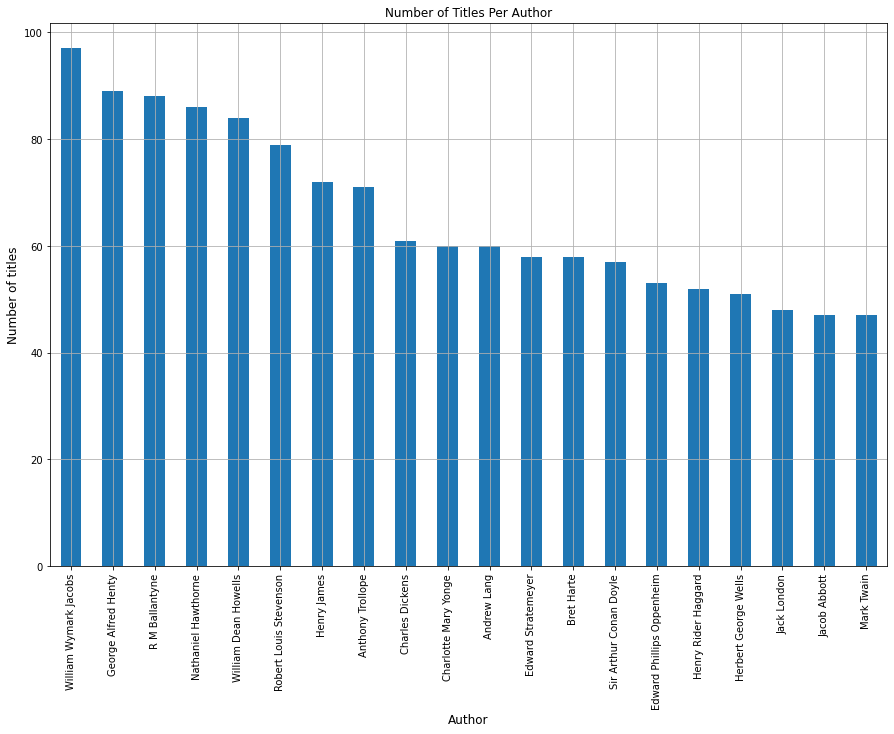

In [37]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

counts_df.plot(x='author', y='title_count', kind='bar', legend=False, grid=True, figsize=(15, 10));
plt.title("Number of Titles Per Author");
plt.ylabel('Number of titles', fontsize=12);
plt.xlabel('Author', fontsize=12);

In [38]:
train_test_df = result_df[result_df.author.isin(counts_df.author)]

In [39]:
from sklearn.model_selection import train_test_split

X = train_test_df.text
y = train_test_df.author

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y, shuffle = True)

In [40]:
X_train.shape
X_test.shape

(1054,)

(264,)

In [41]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english') + list(string.punctuation))

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import VotingClassifier

voting_pipeline = Pipeline([('vect', TfidfVectorizer(stop_words=stop_words)),
               ('tfidf', TfidfTransformer()),
               ('clf', VotingClassifier(estimators=[('lr', LogisticRegression(n_jobs=-1, C=1e5)), ('nb', MultinomialNB()), ('sgd', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))], voting='hard')),
              ])

In [42]:
# If the folder that stores the classifier does not exist, create it
if os.path.isdir('./data/trained-models') == False:
    print("trained-models folder did not exist. Now it does!!!")
    os.mkdir('./data/trained-models')
else:
    print("Folder trained-models already exists in the data folder")

Folder trained-models already exists in the data folder


In [43]:
import joblib
voting_clf = voting_pipeline.fit(X_train, y_train)
joblib.dump(voting_clf, f"./data/trained-models/voting-clf_model.pkl")

['./data/trained-models/voting-clf_model.pkl']

In [44]:
%%time

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = voting_clf.predict(X_test)

print('accuracy ', accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy  0.8068181818181818
                           precision    recall  f1-score   support

              Andrew Lang       0.92      1.00      0.96        12
         Anthony Trollope       0.79      0.79      0.79        14
               Bret Harte       0.79      0.92      0.85        12
          Charles Dickens       0.70      0.58      0.64        12
     Charlotte Mary Yonge       0.50      0.33      0.40        12
Edward Phillips Oppenheim       0.71      0.45      0.56        11
       Edward Stratemeyer       0.92      0.92      0.92        12
      George Alfred Henty       0.73      0.89      0.80        18
              Henry James       0.89      0.57      0.70        14
      Henry Rider Haggard       0.75      0.60      0.67        10
     Herbert George Wells       0.73      0.80      0.76        10
              Jack London       1.00      0.90      0.95        10
             Jacob Abbott       0.80      0.89      0.84         9
               Mark Twain       

In [18]:
#!pip freeze > requirements_01.txt

In [19]:
# PROJECT GUTENBERG DATA SOURCE:

# Gutenberg source: https://web.eecs.umich.edu/~lahiri/gutenberg_dataset.html

# @InProceedings{lahiri:2014:SRW,
#   author    = {Lahiri, Shibamouli},
#   title     = {{Complexity of Word Collocation Networks: A Preliminary Structural Analysis}},
#   booktitle = {Proceedings of the Student Research Workshop at the 14th Conference of the European Chapter of the Association for Computational Linguistics},
#   month     = {April},
#   year      = {2014},
#   address   = {Gothenburg, Sweden},
#   publisher = {Association for Computational Linguistics},
#   pages     = {96--105},
#   url       = {http://www.aclweb.org/anthology/E14-3011}
# }